In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Clean and Merge Data

In [2]:
df = pd.read_csv('wr_stats.csv')

# df = pd.concat([te_stats, wr_stats])

# clean columns
df.columns = df.columns.str.lower()
df['player'] = df['player'].apply(lambda x: ' '.join(x.split()[:-1]))
df['firstName'] = df.player.str.split().str[0]
df['lastName'] = df.player.str.split().str[1]
df.yds = pd.to_numeric(df.yds.str.replace(',', ''))

df

,rank,player,rec,tgt,yds,y/r,lg,20+,td,att,yds.1,td.1,fl,g,fpts,fpts/g,own,year,firstName,lastName
0,1,Tyreek Hill,87,137,1479,17.0,75,55,12,22,151,1,0,16,241.0,15.1,99.9%,2018,Tyreek,Hill
1,2,Antonio Brown,104,168,1297,12.5,78,33,15,0,0,0,0,15,219.7,14.6,0.2%,2018,Antonio,Brown
2,3,Davante Adams,111,169,1386,12.5,57,33,13,0,0,0,0,15,218.6,14.6,99.9%,2018,Davante,Adams
3,4,DeAndre Hopkins,115,163,1572,13.7,49,36,11,1,-7,0,2,16,218.5,13.7,97.1%,2018,DeAndre,Hopkins
4,5,Julio Jones,113,170,1677,14.8,58,37,8,2,12,0,2,16,212.9,13.3,7.2%,2018,Julio,Jones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,445,Braylon Sanders,2,3,17,8.5,13,0,0,0,0,0,1,2,-0.3,-0.2,0.0%,2022,Braylon,Sanders
1508,446,Ihmir Smith-Marsette,1,4,15,15.0,15,0,0,1,-1,0,1,4,-0.6,-0.2,0.0%,2022,Ihmir,Smith-Marsette
1509,447,Deonte Harty,2,2,13,6.5,9,0,0,0,0,0,1,4,-0.7,-0.2,0.3%,2022,Deonte,Harty
1510,448,KaVontae Turpin,1,2,9,9.0,9,0,0,3,17,0,2,17,-1.4,-0.1,0.2%,2022,KaVontae,Turpin


In [3]:
def clean_file(df, year):
    new_df = df.copy()
    new_df.Player = new_df.Player.str.replace('[*+]', '', regex = True)
    new_df['firstName'] = new_df.Player.str.split().str[0]
    new_df['lastName'] = new_df.Player.str.split().str[1]
    new_df['year'] = year
    new_df = new_df[['Tm', 'Age', 'firstName', 'lastName', 'year']]
    
    return new_df

In [4]:
df_18 = pd.read_csv('receiver_stats_2018.txt')
df_clean_18 = clean_file(df_18, 2018)

df_19 = pd.read_csv('receiver_stats_2019.txt')
df_clean_19 = clean_file(df_19, 2019)

df_20 = pd.read_csv('receiver_stats_2020.txt')
df_clean_20 = clean_file(df_20, 2020)

df_21 = pd.read_csv('receiver_stats_2021.txt')
df_clean_21 = clean_file(df_21, 2021)

df_22 = pd.read_csv('receiver_stats_2022.txt')
df_clean_22 = clean_file(df_22, 2022)

In [5]:
# concat and merge dataframes
df = df.copy()
df_combined = pd.concat([df_clean_18, df_clean_19, df_clean_20, df_clean_21, df_clean_22], ignore_index = True)
df_merged = pd.merge(df, df_combined, on = ['firstName', 'lastName', 'year'], how = 'inner')

# create experience variable


# filter down to running backs who play
df_merged = df_merged[(df_merged.tgt > 50) & (df_merged.fpts > 0)]
df_merged.sort_values(by  = 'fpts', ascending = False).head()

,rank,player,rec,tgt,yds,y/r,lg,20+,td,att,...,fl,g,fpts,fpts/g,own,year,firstName,lastName,Tm,Age
643,1,Cooper Kupp,145,191,1947,13.4,59,57,16,4,...,0,17,294.5,17.3,99.9%,2021,Cooper,Kupp,LAR,28
644,2,Deebo Samuel,77,121,1405,18.2,83,53,6,59,...,2,16,262.0,16.4,98.6%,2021,Deebo,Samuel,SFO,25
428,1,Davante Adams,115,149,1374,11.9,56,34,18,0,...,1,14,243.4,17.4,99.9%,2020,Davante,Adams,GNB,28
429,2,Tyreek Hill,87,135,1276,14.7,75,38,15,13,...,0,15,241.9,16.1,99.9%,2020,Tyreek,Hill,KAN,26
0,1,Tyreek Hill,87,137,1479,17.0,75,55,12,22,...,0,16,241.0,15.1,99.9%,2018,Tyreek,Hill,KAN,24


In [6]:
df_merged[df_merged.player == 'DeAndre Hopkins']

,rank,player,rec,tgt,yds,y/r,lg,20+,td,att,...,fl,g,fpts,fpts/g,own,year,firstName,lastName,Tm,Age
3,4,DeAndre Hopkins,115,163,1572,13.7,49,36,11,1,...,2,16,218.5,13.7,97.1%,2018,DeAndre,Hopkins,HOU,26
220,9,DeAndre Hopkins,104,150,1165,11.2,43,24,7,2,...,0,15,165.5,11.0,97.1%,2019,DeAndre,Hopkins,HOU,27
436,10,DeAndre Hopkins,115,160,1407,12.2,60,35,6,1,...,2,16,172.8,10.8,97.1%,2020,DeAndre,Hopkins,ARI,28
679,39,DeAndre Hopkins,42,64,572,13.6,55,13,8,0,...,0,10,105.2,10.5,97.1%,2021,DeAndre,Hopkins,ARI,29
913,49,DeAndre Hopkins,64,96,717,11.2,33,10,3,0,...,1,9,87.7,9.7,97.1%,2022,DeAndre,Hopkins,ARI,30


# Create Pred DF

In [7]:
# create dataframe that will contain target variable
df_pvt = df_merged.pivot_table(values = 'fpts/g', columns = 'year', index = 'player').fillna(0).reset_index()
df_pvt.head()

year,player,2018,2019,2020,2021,2022
0,A.J. Brown,0.0,10.3,12.7,9.1,12.4
1,A.J. Green,11.5,0.0,4.0,6.4,0.0
2,Adam Humphries,7.0,0.0,0.0,2.3,0.0
3,Adam Thielen,12.1,0.0,12.0,10.2,6.5
4,Albert Wilson,0.0,3.6,0.0,0.0,0.0


In [8]:
pred_df = df_merged.loc[df_merged.year == 2021, ['player', 'fpts/g', 'Age']].reset_index(drop = True)

# merge in 2022 stats
pred_df = pd.merge(pred_df, df_pvt, on = 'player', how = 'left').fillna(0)
pred_df.columns = ['player', 'fpts/g', 'Age' ,'2018', '2019', '2020', '2021', 'fpts/g_2022']
pred_df = pred_df.loc[(pred_df['fpts/g'] > 5) & (pred_df['fpts/g_2022'] > 5),['player', 'fpts/g', 'Age', 'fpts/g_2022']]\
                 .reset_index(drop = True)

pred_df

,player,fpts/g,Age,fpts/g_2022
0,Cooper Kupp,17.3,28,14.0
1,Deebo Samuel,16.4,25,8.6
2,Ja'Marr Chase,13.2,21,12.0
3,Justin Jefferson,13.1,22,14.2
4,Davante Adams,13.8,29,13.9
5,Mike Evans,11.8,28,9.9
6,Tyreek Hill,10.9,27,13.1
7,Stefon Diggs,10.7,28,12.4
8,Mike Williams,10.7,27,8.7
9,Tyler Lockett,10.5,29,9.6


# Data Exploration

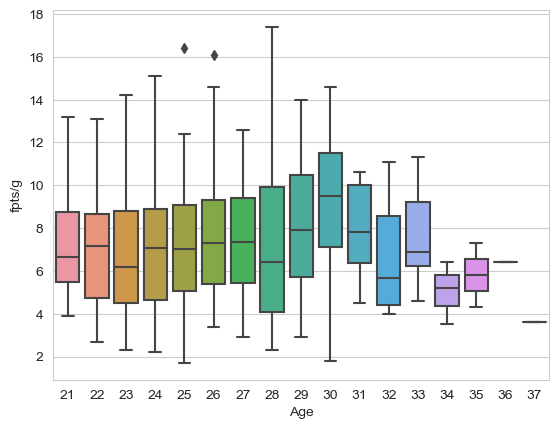

In [9]:
plt.figure()
sns.boxplot(data = df_merged, x = 'Age', y = 'fpts/g')
plt.show()

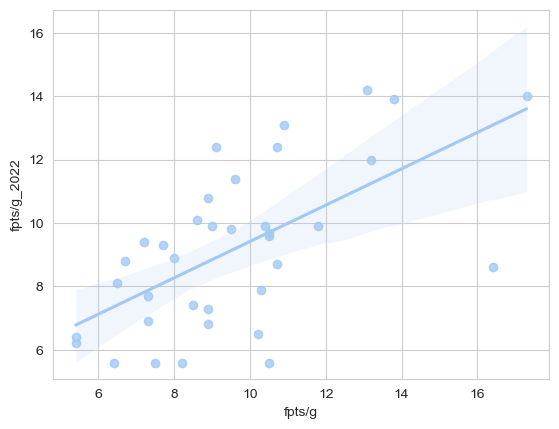

In [10]:
plt.figure()
sns.regplot(data = pred_df, x = 'fpts/g', y='fpts/g_2022')
plt.show()

<AxesSubplot:>

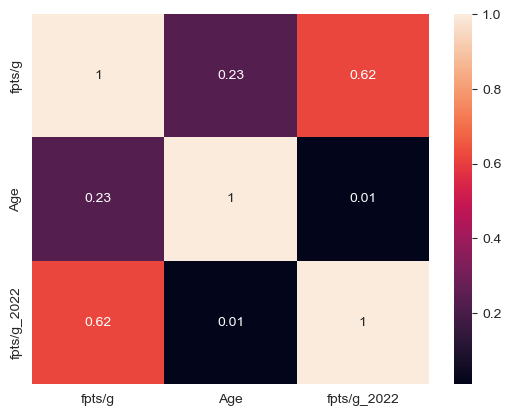

In [11]:
sns.heatmap(pred_df.corr().round(2), annot = True)

# Modeling

In [12]:
predictors = ['fpts/g', 'Age']
target = 'fpts/g_2022'

X = pred_df[predictors]
y = pred_df[target]


# split data into train/test seet
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 42)


# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Random Forest Regressor

In [13]:
# create model
rf = RandomForestRegressor(n_estimators = 100, max_depth = 5, min_samples_split = 6)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=5, min_samples_split=6)

# Linear Regression

In [14]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

LinearRegression()

# Polynomial Regression

In [15]:
poly = PolynomialFeatures(degree = 2, include_bias = False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)

poly_reg = LinearRegression()
poly_reg.fit(X_train_scaled_poly, y_train)

LinearRegression()

# Evaluate Models Above

In [16]:
# make predictions
rf_predictions = rf.predict(X_test_scaled)
reg_predictions = reg.predict(X_test_scaled)

# fit test dataframe with polynomial features before making prediction
X_test_scaled_poly = poly.fit_transform(X_test_scaled)
poly_predictions = poly_reg.predict(X_test_scaled_poly)


# evalate average error
rf_error = mean_absolute_error(y_test, rf_predictions)
reg_error = mean_absolute_error(y_test, reg_predictions)
poly_error = mean_absolute_error(y_test, poly_predictions)

In [17]:
print(rf_error)
print(reg_error)
print(poly_error)

2.528098272907647
1.5946999135678117
2.0605791677964675
